# Hotel Booking Prediction

Dataset of booking information for a city hotel and a resort hotel with information including when the booking was made, length of stay, number of adults, children, and babies, country, arrival date, etc. 

Can be used to understand the clientel of the hotel (families, country of origin, when booked through an agent, repeat customer) and predict whether they will cancel the reservation. This can be helpful when determining how to price their rooms and if they can overbook, given an expected number of cancellations.

Data source: https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand/data

### Environment

In [2]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.10 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.
[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


### Imports

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import f_regression, mutual_info_regression

### Load Data

In [47]:
df = pd.read_csv("hotel_bookings.csv")
df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,2015-07-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07


## Data Cleaning

In [5]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,2016.156554,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122,0.062518,0.571363
std,0.482918,106.863097,0.707476,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790,0.245291,0.792798
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000,0.000000,0.000000
75%,1.000000,160.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

### Null Values

In [48]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [49]:
#Replace missing values
df['country'].fillna("UNK", inplace=True)
df.fillna(0, inplace=True) #this fills children, agent, and company
df['meal'].replace("Undefined", "SC", inplace=True) #Undefined is the same as SC
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

#### Drop Rows with no guests

In [50]:
#Drop rows with no guests: 0 adults, 0 children, and 0 babies
no_guests = df[(df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0)]
print(no_guests.shape)
df = df.drop(no_guests.index)
print(df.shape)

(180, 32)
(119210, 32)


## EDA

In [10]:
df['hotel'].value_counts(sort=False)

hotel
Resort Hotel    40047
City Hotel      79163
Name: count, dtype: int64

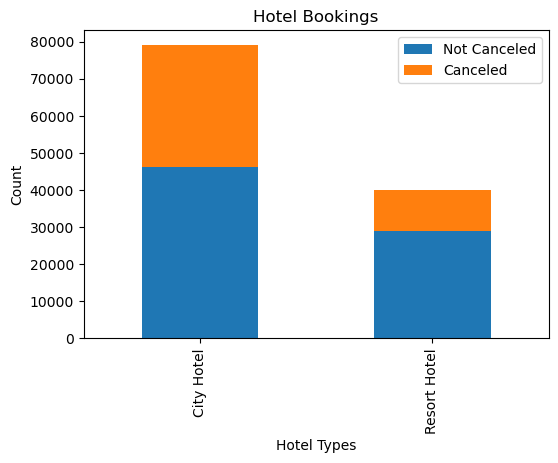

In [11]:
# #Hotel Bookings Bar chart
# plt.figure(figsize=(6,4))
# pd.value_counts(df['hotel']).plot.bar()
# plt.xlabel('Hotel Types')
# plt.ylabel('Count')
# plt.title('Hotel Bookings')
# plt.show()

# Group the data by 'hotel' and 'is_canceled', and count the occurrences
data = df.groupby(['hotel', 'is_canceled']).size().unstack(fill_value=0)

# Create a stacked bar plot
ax = data.plot(kind='bar', stacked=True, figsize=(6, 4))

# Add labels and a legend
plt.xlabel('Hotel Types')
plt.ylabel('Count')
plt.title('Hotel Bookings')
plt.legend(labels=['Not Canceled', 'Canceled'])

# Show the plot
plt.show()

In [12]:
#Cancellations
rh = df.loc[df["hotel"] == "Resort Hotel"]
ch = df.loc[df["hotel"] == "City Hotel"]

total_cancel = df["is_canceled"].sum()
t_cancel_percent = total_cancel/df.shape[0] * 100
rh_cancel = rh["is_canceled"].sum()
rh_cancel_percent = rh_cancel/rh.shape[0] * 100
ch_cancel = ch["is_canceled"].sum()
ch_cancel_percent = ch_cancel/ch.shape[0] * 100

print(f"Total bookings canceled: {total_cancel:,} ({t_cancel_percent:.0f} %)")
print(f"Resort hotel bookings canceled: {rh_cancel:,} ({rh_cancel_percent:.0f} %)")
print(f"City hotel bookings canceled: {ch_cancel:,} ({ch_cancel_percent:.0f} %)")

Total bookings canceled: 44,199 (37 %)
Resort hotel bookings canceled: 11,120 (28 %)
City hotel bookings canceled: 33,079 (42 %)


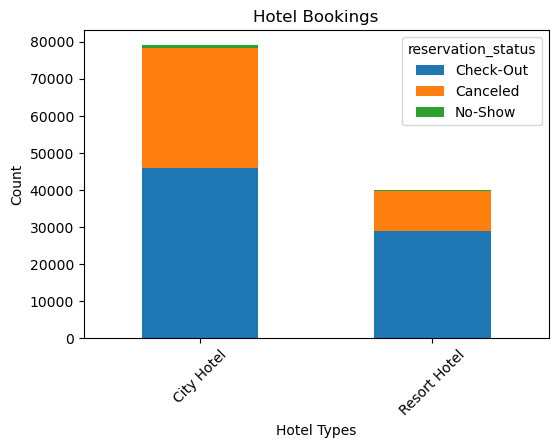

In [13]:
# Group the data by 'hotel' and 'reservation-status', and count the occurrences
data = df.groupby(['hotel', 'reservation_status']).size().unstack(fill_value=0)

# Sort the data by the total counts in descending order
data = data[data.sum().sort_values(ascending=False).index]

# Create a stacked bar plot
ax = data.plot(kind='bar', stacked=True, figsize=(6, 4))

# Add labels and a legend
plt.xlabel('Hotel Types')
plt.ylabel('Count')
plt.title('Hotel Bookings')
plt.xticks(rotation=45)
plt.show()

arrival_date_month
April        40.783535
August       37.782267
December     35.034768
February     33.445107
January      30.501604
July         37.464410
June         41.485955
March        32.227682
May          39.702886
November     31.309999
October      38.090966
September    39.190476
dtype: float64


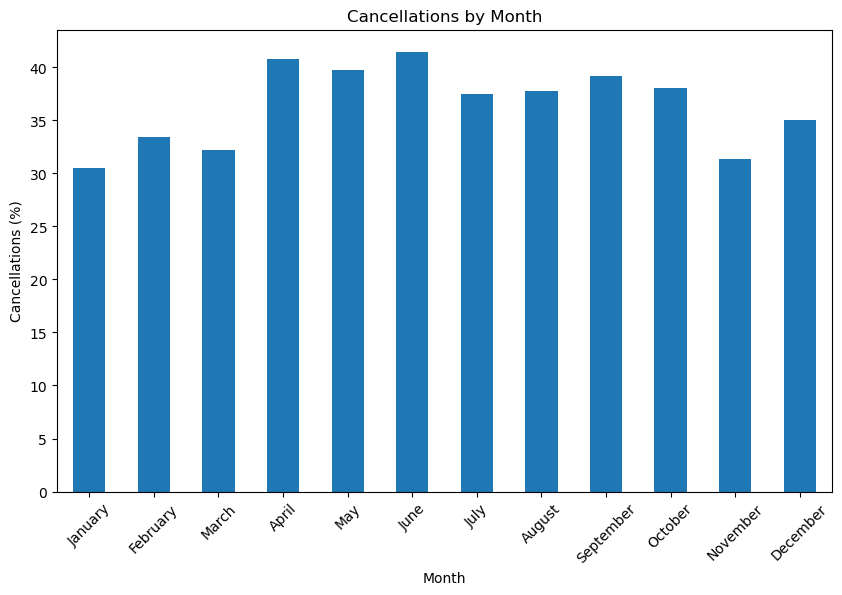

In [129]:
cancel_data = df[df['is_canceled'] == 1].groupby('arrival_date_month').size()
#print(cancel_data)
book_per_month = df.groupby("arrival_date_month").size()
#print(book_per_month)
data = cancel_data/book_per_month * 100

#Use just this for absolute number of cancellations
#data = df[df['is_canceled'] == 1].groupby('arrival_date_month').size()
print(data)

# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Create a bar chart
plt.figure(figsize=(10, 6))
data = data.reindex(month_order, fill_value=0)  # Ensure all months are included
data.plot(kind='bar')
plt.xlabel('Month')
plt.ylabel('Cancellations (%)')
plt.title('Cancellations by Month')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Show the plot
plt.show()

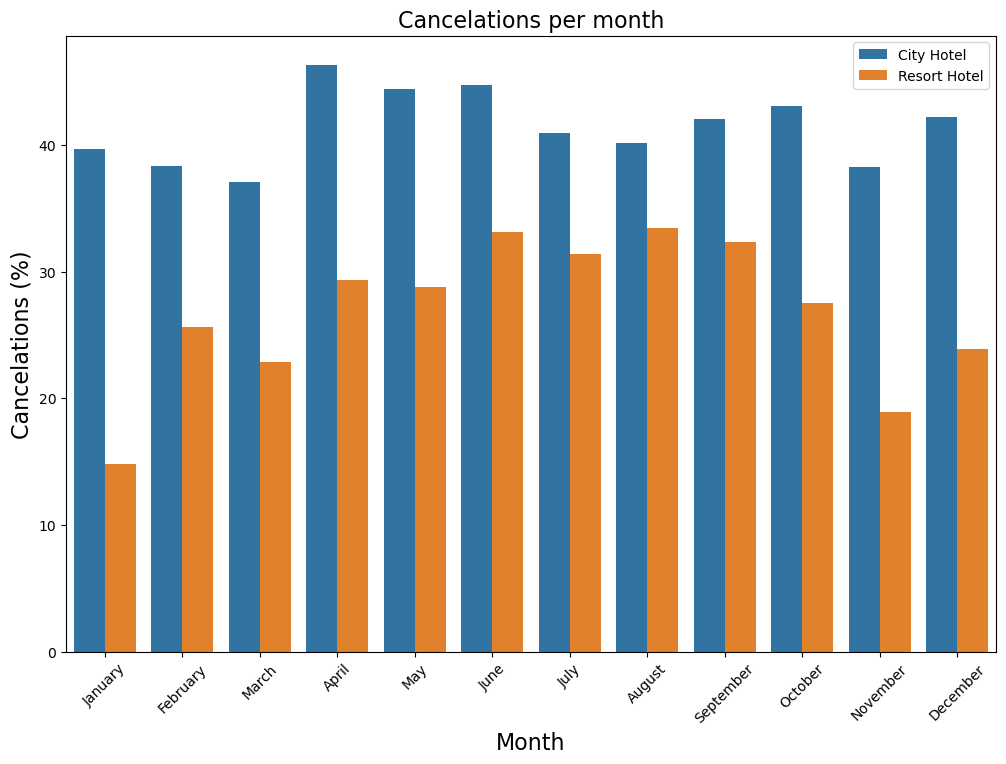

In [15]:
# Create a DateFrame with the relevant data
res_book_per_month = df.loc[(df["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
res_cancel_per_month = df.loc[(df["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

city_book_per_month = df.loc[(df["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
city_cancel_per_month = df.loc[(df["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

res_cancel_data = pd.DataFrame({"Hotel": "Resort Hotel",
                                "Month": list(res_book_per_month.index),
                                "Bookings": list(res_book_per_month.values),
                                "Cancelations": list(res_cancel_per_month.values)})
city_cancel_data = pd.DataFrame({"Hotel": "City Hotel",
                                "Month": list(city_book_per_month.index),
                                "Bookings": list(city_book_per_month.values),
                                "Cancelations": list(city_cancel_per_month.values)})

cancel_data = pd.concat([res_cancel_data, city_cancel_data], ignore_index=True)
cancel_data["cancel_percent"] = cancel_data["Cancelations"] / cancel_data["Bookings"] * 100

# Order by month
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
cancel_data["Month"] = pd.Categorical(cancel_data["Month"], categories=ordered_months, ordered=True)

# Show figure
plt.figure(figsize=(12, 8))
sns.barplot(x = "Month", y = "cancel_percent" , hue="Hotel",
            hue_order = ["City Hotel", "Resort Hotel"], data=cancel_data)
plt.title("Cancelations per month", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("Cancelations (%)", fontsize=16)
plt.legend(loc="upper right")
plt.show()

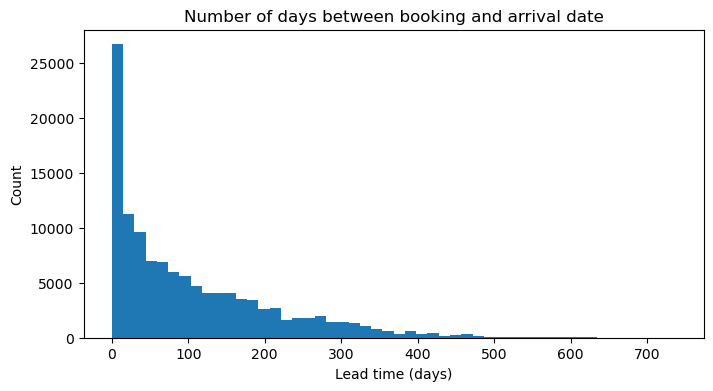

In [62]:
# lead_time (in days-histogram)
plt.figure(figsize=(8,4))
df['lead_time'].plot.hist(bins = 50) 

plt.xlabel('Lead time (days)')
plt.ylabel('Count')
plt.title('Number of days between booking and arrival date')
plt.show()

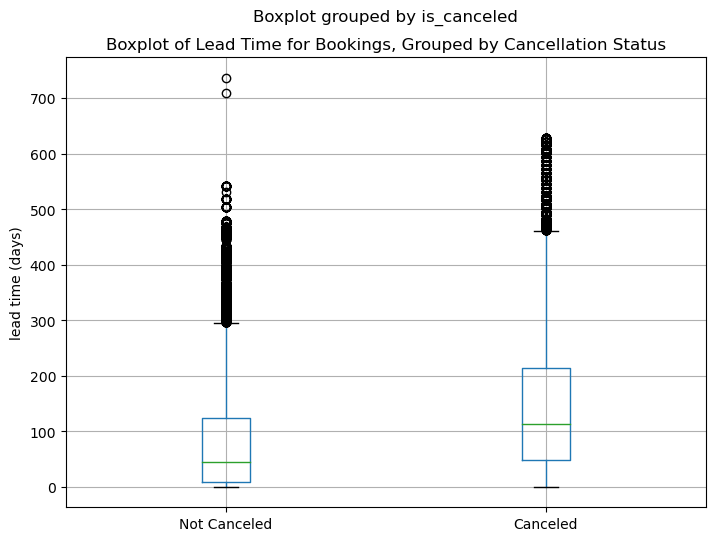

In [77]:
df[['lead_time','is_canceled']].boxplot(by='is_canceled',figsize=(8,6))
plt.xticks([1,2],['Not Canceled', 'Canceled'])
plt.xlabel('')
plt.ylabel('lead time (days)')
plt.title("Boxplot of Lead Time for Bookings, Grouped by Cancellation Status")
plt.show()

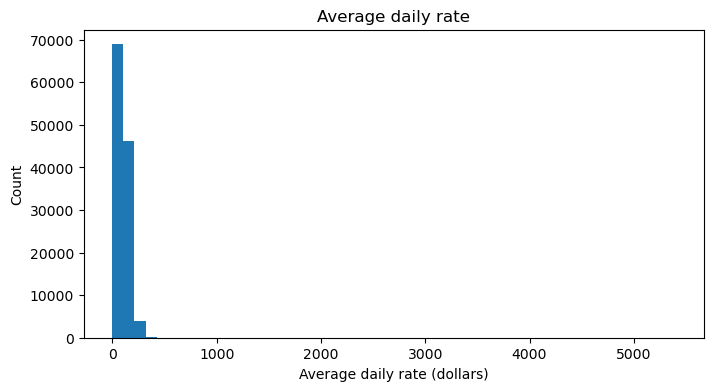

In [88]:
#Average daily rate
plt.figure(figsize=(8,4))
df['adr'].plot.hist(bins = 50) 

plt.xlabel('Average daily rate (dollars)')
plt.ylabel('Count')
plt.title('Average daily rate')
plt.show()

               Hotel   Month  Average Daily Rate
0       Resort Hotel    July                0.00
1       Resort Hotel    July                0.00
2       Resort Hotel    July               75.00
3       Resort Hotel    July               75.00
4       Resort Hotel    July               98.00
...              ...     ...                 ...
119385    City Hotel  August               96.14
119386    City Hotel  August              225.43
119387    City Hotel  August              157.71
119388    City Hotel  August              104.40
119389    City Hotel  August              151.20

[119209 rows x 3 columns]


<Axes: title={'center': 'Average Daily Rate by Month'}, xlabel='Month', ylabel='Average Daily Rate'>

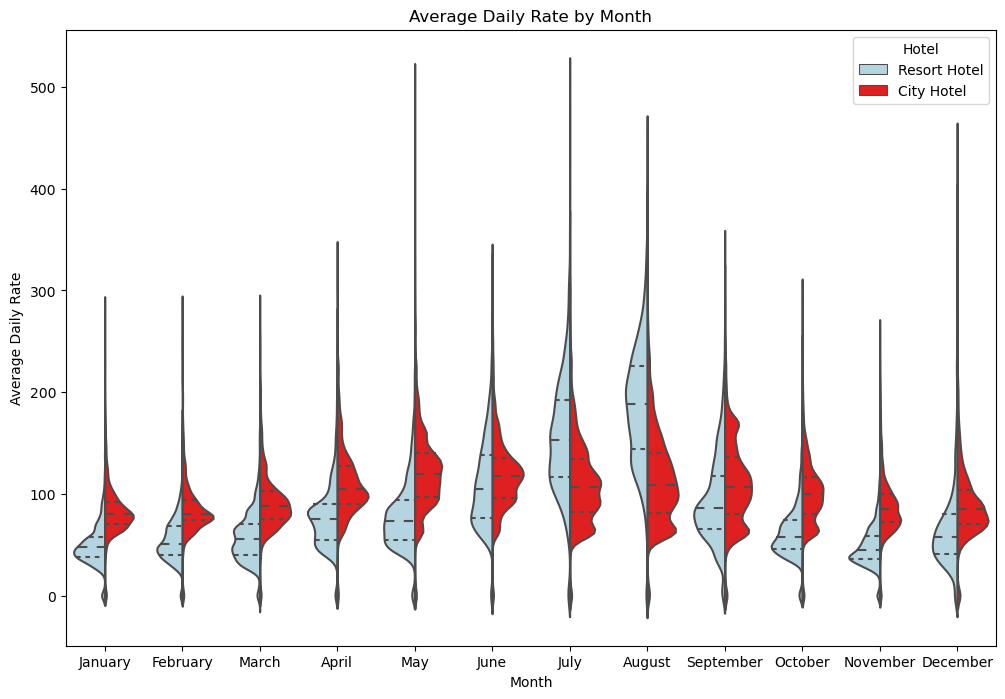

In [78]:
adr_data = df[['hotel', 'arrival_date_month', 'adr']]
adr_data = adr_data[adr_data['adr'] < 5000] #one weird outlier in March that makes it hard to visualize
# Define a dictionary to map old column names to new column names
column_name_mapping = {
    'hotel': 'Hotel',
    'arrival_date_month': 'Month',
    'adr': 'Average Daily Rate'
}

adr_data.rename(columns=column_name_mapping, inplace=True)
print(adr_data)

# Order by month
ordered_months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
adr_data["Month"] = pd.Categorical(adr_data["Month"], categories=ordered_months, ordered=True)

plt.figure(figsize=(12, 8))
plt.title("Average Daily Rate by Month")
sns.violinplot(data=adr_data, x="Month", y="Average Daily Rate", hue="Hotel",
               split=True, inner="quartile", fill=True,
               palette={"Resort Hotel": "lightblue", "City Hotel": "red"})


In [79]:
# # Create a DateFrame with the relevant data
# res_book_per_month = df.loc[(df["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
# #print(res_book_per_month)
# res_adr_per_month = df.loc[(df["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["adr"].agg(list)

# #print(res_adr_per_month)

# city_book_per_month = df.loc[(df["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
# city_adr_per_month = df.loc[(df["hotel"] == "City Hotel")].groupby("arrival_date_month")["adr"].agg(list)
# #print(city_adr_per_month)
# res_adr_data = pd.DataFrame({"Hotel": "Resort Hotel",
#                                 "Month": list(res_book_per_month.index),
#                                 "Adr": list(res_adr_per_month)})
# city_adr_data = pd.DataFrame({"Hotel": "City Hotel",
#                                 "Month": list(city_book_per_month.index),
#                                 "Adr": list(city_adr_per_month)})

# adr_data = pd.concat([res_adr_data, city_adr_data], ignore_index=True)
# #print(adr_data)
# # Order by month
# ordered_months = ["January", "February", "March", "April", "May", "June", 
#           "July", "August", "September", "October", "November", "December"]
# adr_data["Month"] = pd.Categorical(adr_data["Month"], categories=ordered_months, ordered=True)

# # Show figure
# plt.violinplot(dataset = adr_data['Adr'])
# plt.title('Average Daily Rate Distribution by Month')
# plt.xlabel('Month', fontsize=16)
# plt.ylabel('Average Daily Rate (euros)', fontsize=16)
# plt.xticks([1,2],['Resort Hotel','City Hotel'], rotation=0)
# plt.legend(adr_data["Hotel"].unique(), title='Hotel Type')
# plt.show()

deposit_type
No Deposit    28.401987
Non Refund    99.362446
Refundable    22.222222
Name: mean, dtype: float64


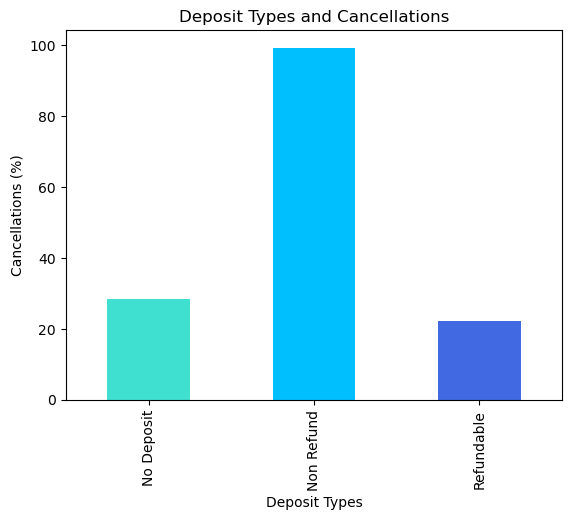

In [101]:
#deposit type (categorical)
data = df.groupby("deposit_type")["is_canceled"].describe()
data = data["mean"] * 100
print(data)
# Create a bar plot
data.plot(kind='bar', color=['turquoise', 'deepskyblue', 'royalblue'])
# Add labels and a legend
plt.xlabel('Deposit Types')
plt.ylabel('Cancellations (%)')
plt.title('Deposit Types and Cancellations')
plt.show()

## Duplicates
Since there is no visitor id, duplicates don't have any bearing on each other (could be multiple bookings on the same day for the same room type for the same vacation week)

In [132]:
print(len(df))
duplicate_rows_count = df[df.duplicated(keep=False)].shape[0]
print("Number of duplicate rows:", duplicate_rows_count)

119210
Number of duplicate rows: 40141


## Preprocessing

In [ ]:
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
reservation_status                0
reservation_status_date           0
dtype: int64

In [165]:
# don't include: reservation_status (leakage), booking_changes (changes over time)
#Consider: # (arrival_date_year, assigned_room_type, country, booking_changes, reservation_status
# days_in_waiting_list)
num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month", "arrival_date_year",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies", "previous_cancellations","previous_bookings_not_canceled",
                "days_in_waiting_list","required_car_parking_spaces", 
                "total_of_special_requests", "adr", "agent"]

cat_features = ["hotel","arrival_date_month","meal","market_segment", "company", "assigned_room_type",
                "distribution_channel","reserved_room_type","deposit_type","customer_type", "is_repeated_guest","country"]

features = num_features + cat_features
X = df.drop(["is_canceled"], axis=1)[features]
y = df["is_canceled"]

#Do stratified split based on 'hotel'
X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,stratify=df['hotel'],random_state=42)
print('Test balance:',np.unique(y_test,return_counts=True))
print("Train/Val Shape:", X_other.shape, "Test Shape:", X_test.shape)

kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
for train_index, val_index in kf.split(X_other,y_other):
    print('new fold')
    X_train = X_other.iloc[train_index]
    y_train = y_other.iloc[train_index]
    X_val = X_other.iloc[val_index]
    y_val = y_other.iloc[val_index]
    print(np.unique(y_train,return_counts=True))
    print(np.unique(y_val,return_counts=True))

print("X_train", X_train.shape)
print("X_val",X_val.shape)
print("X_test",X_test.shape)

Test balance: (array([0, 1]), array([14882,  8960]))
Train/Val Shape: (95368, 28) Test Shape: (23842, 28)
new fold
(array([0, 1]), array([48103, 28191]))
(array([0, 1]), array([12026,  7048]))
new fold
(array([0, 1]), array([48103, 28191]))
(array([0, 1]), array([12026,  7048]))
new fold
(array([0, 1]), array([48103, 28191]))
(array([0, 1]), array([12026,  7048]))
new fold
(array([0, 1]), array([48103, 28192]))
(array([0, 1]), array([12026,  7047]))
new fold
(array([0, 1]), array([48104, 28191]))
(array([0, 1]), array([12025,  7048]))
X_train (76295, 28)
X_val (19073, 28)
X_test (23842, 28)


In [166]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), cat_features),
        ('std', StandardScaler(), num_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)

print("X_train", X_train.shape)
print("X_val",X_val.shape)
print("X_test",X_test.shape)
print("X_train_prep", X_train_prep.shape)
print("X_val_prep",X_val_prep.shape)
print("X_test_prep",X_test_prep.shape)

X_train (76295, 28)
X_val (19073, 28)
X_test (23842, 28)
X_train_prep (76295, 545)
X_val_prep (19073, 545)
X_test_prep (23842, 545)


## Correlation

In [167]:
# f_test, p_values = f_regression(X_train_prep, y_train)
# print('f score',f_test)
# print('p values',p_values)
#corr_data = pd.DataFrame(X_train_prep)
cancel_corr = df.corr(numeric_only=True)['is_canceled']
cancel_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.292876
total_of_special_requests         0.234877
required_car_parking_spaces       0.195701
booking_changes                   0.144832
previous_cancellations            0.110139
is_repeated_guest                 0.083745
company                           0.083594
adults                            0.058182
previous_bookings_not_canceled    0.057365
days_in_waiting_list              0.054301
agent                             0.046770
adr                               0.046492
babies                            0.032569
stays_in_week_nights              0.025542
arrival_date_year                 0.016622
arrival_date_week_number          0.008315
arrival_date_day_of_month         0.005948
children                          0.004851
stays_in_weekend_nights           0.001323
Name: is_canceled, dtype: float64

In [160]:
# sns.heatmap(cancel_corr, annot = True, linewidths = 1)
# plt.show()